In [24]:
from datasets import load_dataset
import pandas as pd
import os
from dotenv import load_dotenv
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import pandas
import json
import re
import numpy as np
import openai


from sklearn.metrics.pairwise import cosine_similarity
from pprint import pprint
from pathlib import Path

from langchain.embeddings import OpenAIEmbeddings

In [2]:
dataset = load_dataset("jerteh/SrpWiki")
dataset2 = load_dataset("jerteh/SrpKorNews")

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 3818535
    })
})

In [4]:
dataset['train']

Dataset({
    features: ['text'],
    num_rows: 3818535
})

In [5]:
wikiText = dataset['train']['text']
len(wikiText)

3818535

In [6]:
type(wikiText)

list

In [7]:
for i in range(10):
    print(wikiText[i])

UTF-8 UTF-8 varijanta je najzgodnija za kodiranje većinski latiničnog teksta.
Dato je i kratko uputstvo za korišćenje te varijante u Microsoft Word-u, Netscape Composer-u i tekstualnom editoru Kate.
U tekstu su takođe preporučeni standardni Unicode fontovi koji omogućavaju laku prenosivost teksta sa računara na računar ili za objavljivanje teksta na Internet.
Prvi računari su bili pravljeni pretežno za englesko govorno područje i imali su podršku samo za engleski alfabet, za brojeve, zagrade i još po neki kontrolni karakter, što je činilo ukupno 128 mogućih slova (u 7 bita).
To je bio tzv. "-{ASCII}-" ili "-{US-ASCII}-" standard.
1968. godine je skup karaktera proširen na 256 (8 bita), a "gornjih" 128 karaktera je bilo korišćeno za dodatne karaktere.
Iz neke navike je i ovaj prošireni "-{ASCII}-" nazivan "-{ASCII}-", tako da tu često dolazi do zabune.
Da bi postojala podrška za više jezika, smišljane su tzv. kodne strane ("-{Code Page}-") koje definišu ponašanje tog dodatnog skupa slov

In [7]:
dataset2

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 337
    })
})

In [8]:
dataset2['train']

Dataset({
    features: ['text'],
    num_rows: 337
})

In [9]:
newsText = dataset2['train']['text']
print(newsText[:3])
print(len(newsText))

['<s>Mečka na usijanom limenom krovu</s><s>Piše: Dušan Vidaković Kada je austrijski konzul u Nici Emil Jelinek 1901. naručio od nemačkog Dajmlera, odjednom, čak 36 automobila, čija je ukupna cena premašila fantastičnih 550 hiljada zlatnih maraka, imao je samo jedan uslov: da sva ta kola nose ime njegove ćerke.</s><s>Ljudi iz kanstatske firme, naravno, nisu imali ništa protiv, a istorija automobilizma je imala sreću da je Jelinekovoj mezimici kum dao (pogotovo za Špance) vrlo graciozno ime - Mercedes, što na jeziku konkvistadora znaci ljupkost, umilnost, prijatnost.</s><s>Jelinekova porudžbina značila prekretnicu u poslovanju Dajmlera, a naziv Mercedes je preživeo i fuziju sa fabrikom Karla Benca, 1926. godine, održavši se do danas kao sinonim za kvalitetne, luksuzne i, nadasve, bezbedne automobile svojstvenih vozačima koji ne kriju brige u novčaniku.</s><s>Međutim, upravo legenda o blistavosti trokrake zvezde doživljava ovih dana ozbiljnu proveru zahvaljujući mercedesu A klase.</s><s>A

In [11]:
newsText_mini = newsText[:3]
print(newsText_mini)
print(len(newsText_mini))

['<s>Mečka na usijanom limenom krovu</s><s>Piše: Dušan Vidaković Kada je austrijski konzul u Nici Emil Jelinek 1901. naručio od nemačkog Dajmlera, odjednom, čak 36 automobila, čija je ukupna cena premašila fantastičnih 550 hiljada zlatnih maraka, imao je samo jedan uslov: da sva ta kola nose ime njegove ćerke.</s><s>Ljudi iz kanstatske firme, naravno, nisu imali ništa protiv, a istorija automobilizma je imala sreću da je Jelinekovoj mezimici kum dao (pogotovo za Špance) vrlo graciozno ime - Mercedes, što na jeziku konkvistadora znaci ljupkost, umilnost, prijatnost.</s><s>Jelinekova porudžbina značila prekretnicu u poslovanju Dajmlera, a naziv Mercedes je preživeo i fuziju sa fabrikom Karla Benca, 1926. godine, održavši se do danas kao sinonim za kvalitetne, luksuzne i, nadasve, bezbedne automobile svojstvenih vozačima koji ne kriju brige u novčaniku.</s><s>Međutim, upravo legenda o blistavosti trokrake zvezde doživljava ovih dana ozbiljnu proveru zahvaljujući mercedesu A klase.</s><s>A

In [50]:
newsSent = []
for text in newsText_mini:
    matches = re.findall(r'<s>(.*?)</s>', text)
    newsSent.append(matches)

print(newsSent)
print(len(newsSent))

[['Mečka na usijanom limenom krovu', 'Piše: Dušan Vidaković Kada je austrijski konzul u Nici Emil Jelinek 1901. naručio od nemačkog Dajmlera, odjednom, čak 36 automobila, čija je ukupna cena premašila fantastičnih 550 hiljada zlatnih maraka, imao je samo jedan uslov: da sva ta kola nose ime njegove ćerke.', 'Ljudi iz kanstatske firme, naravno, nisu imali ništa protiv, a istorija automobilizma je imala sreću da je Jelinekovoj mezimici kum dao (pogotovo za Špance) vrlo graciozno ime - Mercedes, što na jeziku konkvistadora znaci ljupkost, umilnost, prijatnost.', 'Jelinekova porudžbina značila prekretnicu u poslovanju Dajmlera, a naziv Mercedes je preživeo i fuziju sa fabrikom Karla Benca, 1926. godine, održavši se do danas kao sinonim za kvalitetne, luksuzne i, nadasve, bezbedne automobile svojstvenih vozačima koji ne kriju brige u novčaniku.', 'Međutim, upravo legenda o blistavosti trokrake zvezde doživljava ovih dana ozbiljnu proveru zahvaljujući mercedesu A klase.', 'A sve je, ustvari,

In [79]:
newsSent_first_ten = []

for sublist in newsSent:
    newsSent_first_ten.extend(sublist[:100])

print(newsSent_first_ten)

['Mečka na usijanom limenom krovu', 'Piše: Dušan Vidaković Kada je austrijski konzul u Nici Emil Jelinek 1901. naručio od nemačkog Dajmlera, odjednom, čak 36 automobila, čija je ukupna cena premašila fantastičnih 550 hiljada zlatnih maraka, imao je samo jedan uslov: da sva ta kola nose ime njegove ćerke.', 'Ljudi iz kanstatske firme, naravno, nisu imali ništa protiv, a istorija automobilizma je imala sreću da je Jelinekovoj mezimici kum dao (pogotovo za Špance) vrlo graciozno ime - Mercedes, što na jeziku konkvistadora znaci ljupkost, umilnost, prijatnost.', 'Jelinekova porudžbina značila prekretnicu u poslovanju Dajmlera, a naziv Mercedes je preživeo i fuziju sa fabrikom Karla Benca, 1926. godine, održavši se do danas kao sinonim za kvalitetne, luksuzne i, nadasve, bezbedne automobile svojstvenih vozačima koji ne kriju brige u novčaniku.', 'Međutim, upravo legenda o blistavosti trokrake zvezde doživljava ovih dana ozbiljnu proveru zahvaljujući mercedesu A klase.', 'A sve je, ustvari, 

In [80]:
sentences = [{'sentence': x, 'id' : i} for i, x in enumerate(newsSent_first_ten)]
pprint(sentences)

[{'index': 0, 'sentence': 'Mečka na usijanom limenom krovu'},
 {'index': 1,
  'sentence': 'Piše: Dušan Vidaković Kada je austrijski konzul u Nici Emil '
              'Jelinek 1901. naručio od nemačkog Dajmlera, odjednom, čak 36 '
              'automobila, čija je ukupna cena premašila fantastičnih 550 '
              'hiljada zlatnih maraka, imao je samo jedan uslov: da sva ta '
              'kola nose ime njegove ćerke.'},
 {'index': 2,
  'sentence': 'Ljudi iz kanstatske firme, naravno, nisu imali ništa protiv, a '
              'istorija automobilizma je imala sreću da je Jelinekovoj '
              'mezimici kum dao (pogotovo za Špance) vrlo graciozno ime - '
              'Mercedes, što na jeziku konkvistadora znaci ljupkost, umilnost, '
              'prijatnost.'},
 {'index': 3,
  'sentence': 'Jelinekova porudžbina značila prekretnicu u poslovanju '
              'Dajmlera, a naziv Mercedes je preživeo i fuziju sa fabrikom '
              'Karla Benca, 1926. godine, održavši s

In [81]:
buffer_size = 1

In [82]:
def combine_sentences(sentences, buffer_size=buffer_size):
    # Go through each sentence dict
    for i in range(len(sentences)):

        # Create a string that will hold the sentences which are joined
        combined_sentence = ''

        # Add sentences before the current one, based on the buffer size.
        for j in range(i - buffer_size, i):
            # Check if the index j is not negative (to avoid index out of range like on the first one)
            if j >= 0:
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += sentences[j]['sentence'] + ' '

        # Add the current sentence
        combined_sentence += sentences[i]['sentence']

        # Add sentences after the current one, based on the buffer size
        for j in range(i + 1, i + 1 + buffer_size):
            # Check if the index j is within the range of the sentences list
            if j < len(sentences):
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += ' ' + sentences[j]['sentence']

        # Then add the whole thing to your dict
        # Store the combined sentence in the current sentence dict
        sentences[i]['combined_sentence'] = combined_sentence

    return sentences

In [83]:
sentences = combine_sentences(sentences)
sentences[11]

{'sentence': 'Kako je i red, volana malog automobila najpre su se prihvatili specijalizovani poslenici sedme sile.',
 'index': 11,
 'combined_sentence': 'Najveću sablazan tom prilikom proizvele su patuljaste dimenzije klase A: sa tri i po metra dužine novi merdža je, na primer, 33 santimetra kraći od stojadina. Kako je i red, volana malog automobila najpre su se prihvatili specijalizovani poslenici sedme sile. Njih 1.500 je, tokom dva godišnja doba promotivnih vožnji, prevalilo pola miliona kilometara klasom A bez ikakvih problema i zakeranja, i kada se činilo da ce najnoviji mercedes stići pred kupce sa odličnim preporukama, dogodila se vlažna pista jednog švedskog aerodroma.'}

In [84]:
openai.api_key = os.getenv("OPENAI_API_KEY")
oaiembeds = OpenAIEmbeddings()

In [85]:
embeddings = oaiembeds.embed_documents([x['combined_sentence'] for x in sentences])

In [86]:
for i, sentence in enumerate(sentences):
    sentence['combined_sentence_embedding'] = embeddings[i]

In [87]:
def calculate_cosine_distances(sentences):
    distances = []
    for i in range(len(sentences) - 1):
        embedding_current = sentences[i]['combined_sentence_embedding']
        embedding_next = sentences[i + 1]['combined_sentence_embedding']
        
        # Calculate cosine similarity
        similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]
        
        # Convert to cosine distance
        distance = 1 - similarity

        # Append cosine distance to the list
        distances.append(distance)

        # Store distance in the dictionary
        sentences[i]['distance_to_next'] = distance

    # Optionally handle the last sentence
    # sentences[-1]['distance_to_next'] = None  # or a default value

    return distances, sentences

In [88]:
distances, sentences = calculate_cosine_distances(sentences)

In [89]:
distances[:3]

[0.0151932281728403, 0.01789633610092678, 0.03619731675835591]

In [97]:
sentences[:3]

[{'sentence': 'Mečka na usijanom limenom krovu',
  'index': 0,
  'combined_sentence': 'Mečka na usijanom limenom krovu Piše: Dušan Vidaković Kada je austrijski konzul u Nici Emil Jelinek 1901. naručio od nemačkog Dajmlera, odjednom, čak 36 automobila, čija je ukupna cena premašila fantastičnih 550 hiljada zlatnih maraka, imao je samo jedan uslov: da sva ta kola nose ime njegove ćerke.',
  'combined_sentence_embedding': [0.002644304804022099,
   -0.0021864512331561305,
   0.006650924599906111,
   -0.025626943990934025,
   -0.00021165684793197093,
   -0.0013599051945613423,
   -0.037425106683546754,
   -0.0064581440754897055,
   -0.0045335528257157125,
   -0.03066493933633208,
   -0.0008144972849225948,
   0.014278603608502638,
   0.009420537000912596,
   -0.0036049938973753822,
   -0.023840512590414125,
   0.010307326575037691,
   0.030819164500923306,
   0.0034796867660523106,
   0.015011168949359137,
   -0.029816705587693476,
   -0.03210436737615092,
   -0.013443221180811113,
   0.005

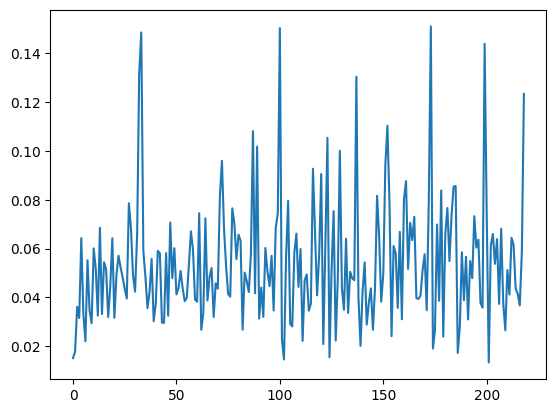

In [90]:
import matplotlib.pyplot as plt

plt.plot(distances)

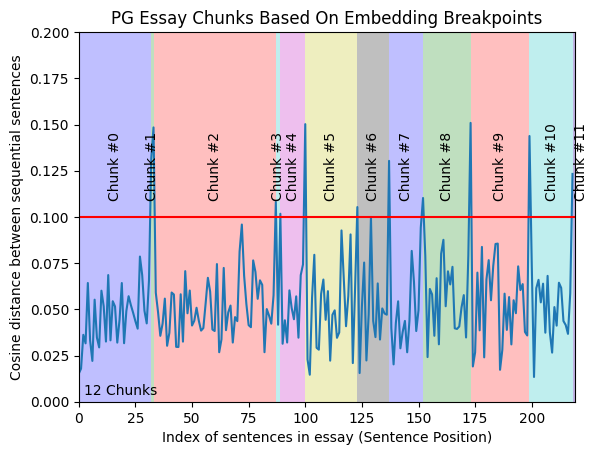

In [91]:
import numpy as np

plt.plot(distances);

y_upper_bound = .2
plt.ylim(0, y_upper_bound)
plt.xlim(0, len(distances))

# We need to get the distance threshold that we'll consider an outlier
# We'll use numpy .percentile() for this
breakpoint_percentile_threshold = 95
breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold) # If you want more chunks, lower the percentile cutoff
plt.axhline(y=breakpoint_distance_threshold, color='r', linestyle='-');

# Then we'll see how many distances are actually above this one
num_distances_above_theshold = len([x for x in distances if x > breakpoint_distance_threshold]) # The amount of distances above your threshold
plt.text(x=(len(distances)*.01), y=y_upper_bound/50, s=f"{num_distances_above_theshold + 1} Chunks");

# Then we'll get the index of the distances that are above the threshold. This will tell us where we should split our text
indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold] # The indices of those breakpoints on your list

# Start of the shading and text
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, breakpoint_index in enumerate(indices_above_thresh):
    start_index = 0 if i == 0 else indices_above_thresh[i - 1]
    end_index = breakpoint_index if i < len(indices_above_thresh) - 1 else len(distances)

    plt.axvspan(start_index, end_index, facecolor=colors[i % len(colors)], alpha=0.25)
    plt.text(x=np.average([start_index, end_index]),
             y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
             s=f"Chunk #{i}", horizontalalignment='center',
             rotation='vertical')

# # Additional step to shade from the last breakpoint to the end of the dataset
if indices_above_thresh:
    last_breakpoint = indices_above_thresh[-1]
    if last_breakpoint < len(distances):
        plt.axvspan(last_breakpoint, len(distances), facecolor=colors[len(indices_above_thresh) % len(colors)], alpha=0.25)
        plt.text(x=np.average([last_breakpoint, len(distances)]),
                 y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
                 s=f"Chunk #{i+1}",
                 rotation='vertical')

plt.title("PG Essay Chunks Based On Embedding Breakpoints")
plt.xlabel("Index of sentences in essay (Sentence Position)")
plt.ylabel("Cosine distance between sequential sentences")
plt.show()

In [92]:
# Initialize the start index
start_index = 0

# Create a list to hold the grouped sentences
chunks = []

# Iterate through the breakpoints to slice the sentences
for index in indices_above_thresh:
    # The end index is the current breakpoint
    end_index = index

    # Slice the sentence_dicts from the current start index to the end index
    group = sentences[start_index:end_index + 1]
    combined_text = ' '.join([d['sentence'] for d in group])
    chunks.append(combined_text)
    
    # Update the start index for the next group
    start_index = index + 1

# The last group, if any sentences remain
if start_index < len(sentences):
    combined_text = ' '.join([d['sentence'] for d in sentences[start_index:]])
    chunks.append(combined_text)

# grouped_sentences now contains the chunked sentences

In [96]:
for i, chunk in enumerate(chunks[:5]):
    buffer = 200
    
    print (f"Chunk #{i}")
    print (chunk[:buffer].strip())
    print ("...")
    print (chunk[-buffer:].strip())
    print ("\n")

Chunk #0
Mečka na usijanom limenom krovu Piše: Dušan Vidaković Kada je austrijski konzul u Nici Emil Jelinek 1901. naručio od nemačkog Dajmlera, odjednom, čak 36 automobila, čija je ukupna cena premašila fanta
...
i-ven ponašao na testu izbegavanja rupa po našim drumovima, koje svakodnevno i uživo upražnjavaju domaći šoferi. I onda sledi logičan zaključak: verovatno zato A klasa još nije stigla na naše tržište.


Chunk #1
Blow up
...
Blow up


Chunk #2
UOBLIČAVANJE SVETOVA IKON knjige - edicija za početnike Piše Nikola Suica Svojevrsni vodiči Za početnike izdavačke kuće Ikona iz Kembridža, trasirani su kao misaoni zadaci saznavanja. Principi i idejn
...
voljstva i zelje, podvlačeći da se zaista sve, makar u pokušaju spoja slike i reči, može podvrći razjašnjavanju i poređenju na mentalnoj mapi odrednica trećeg milenijuma. IZMEĐU PRAVILA I KREATIVNOSTI


Chunk #3
Razgovarala: Olivija Rušovac Dobri dizajneri u Jugoslaviji imaju ideje i obrazovanje, ali ne i novac. On je na nekom drugom me

In [25]:
count = 0
for paragraf in dataset2['train']['text']:
    paragraph_sentences = re.findall(r'<s>(.*?)</s>', paragraf)
    count += len(paragraph_sentences)
    # print(len(sentences))
print(count)

21982152


In [87]:
# for sentence in sentences:
#     print(sentence)

In [84]:
def make_dataset(file_path: Path):
        returned_dict = {
             "context": [],
             "short_query": [],
             "medium_query": [],
             "long_query": [],
             "keywords": []
        }
        # Open and iterate through the .jsonl file
        with open(file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                context = data[-1]['context']
                returned_data = data[1]['choices'][0]['message']['content']
                returned_data = json.loads(returned_data)
                returned_dict['context'].append(context)
                returned_dict['short_query'].append(returned_data['short_query'])
                returned_dict['medium_query'].append(returned_data['medium_query'])
                returned_dict['long_query'].append(returned_data['long_query'])
                returned_dict['keywords'].append(returned_data['keywords'])
        return returned_dict

In [85]:
data_for_df = make_dataset(Path('datasets/training_openai_data.jsonl'))
dataset = pd.DataFrame(data_for_df)

table = pa.Table.from_pandas(dataset)

pq.write_table(table, 'datasets/train.parquet')

In [86]:
dataset.head()

,context,short_query,medium_query,long_query,keywords
0,Drugo rešenje je korišćenje tzv. transformacio...,Šta je Unicode transformaciona šema?,Kako se koristi Unicode transformaciona šema z...,Kako funkcioniše Unicode transformaciona šema ...,"[Unicode, transformacione šeme, UTF-8, latinica]"
1,"To uglavnom nije problem realizovati, ali ako ...",Šta je Junikod?,Kako se rešava problem mešanja dva pisma u tur...,Kako je nastao Junikod i zašto se koristi kao ...,"[Unicode, pisma, turistički vodič, jezici]"
2,"O UTF-8 će biti više reči u poglavlju ""Ukratko...",Šta omogućavaju MIME standardi?,Kako se vrše kodiranje višebitnih reči u Inter...,Koje su razlike između 7-bitnih mail poruka i ...,"[UTF-8, Mail Transfer Agent, MIME standardi, U..."
3,"To je bio tzv. ""-{ASCII}-"" ili ""-{US-ASCII}-"" ...",Šta je bio tzv. ASCII standard?,Kako je proširen ASCII standard 1968. godine i...,Kako su kodne strane smišljene radi podrške za...,"[ASCII, US-ASCII, standard, kodne strane, kara..."
4,Osnovna kodna strana na personalnim računarima...,Koje kodne strane podržavaju različite jezike ...,Kako se različite kodne strane koriste za podr...,"Kako kodne strane kao što su Latin1, Latin2 i ...","[kodna strana, personalni računari, grafika, k..."
